In [1]:
import av
import json
import os

import cv2
from datasets import DatasetDict, load_dataset, load_from_disk
from datasets.combine import concatenate_datasets
from matplotlib import pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoImageProcessor

In [17]:
# store vatex json files as {"videoID" : [captions sorted by word count]}

data_path = "dataset"
for filename in ("vatex_train_captions", "vatex_val_captions"):
    output = {}
    with open(os.path.join(data_path, "%s.json" % filename)) as file:
        data = json.load(file)
        for item in data:
            video_id, captions = item["videoID"], item["enCap"]
            captions.sort(reverse=True, key=lambda cap: len(cap.split()))
            output[video_id] = captions
            
    output = json.dumps(output)
    with open(os.path.join(data_path, "%s_videoID_keys.json" % filename), "w") as file:
        file.write(output)

In [2]:
image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
dataset_train = load_from_disk("dataset/processed/k600")
dataset_train.pop("validation")

dataset_val = load_from_disk("dataset/processed/k600")
dataset_val.pop("train")

print(dataset_train)
print(dataset_val)

DatasetDict({
    train: Dataset({
        features: ['videoID', 'pixel_values', 'labels'],
        num_rows: 1016
    })
})
DatasetDict({
    validation: Dataset({
        features: ['videoID', 'pixel_values', 'labels'],
        num_rows: 117
    })
})


In [4]:
captions_data = {}

with open("dataset/vatex_train_captions_videoID_keys.json") as file:
    captions_data.update(json.load(file))
    
with open("dataset/vatex_val_captions_videoID_keys.json") as file:
    captions_data.update(json.load(file))

def process(example, frames_per_video=8):
    video_id = example["videoID"]
    captions = captions_data[video_id]
    
    videos_path = "dataset/videos"
    video_path = os.path.join(videos_path, "%s.mp4" % video_id)
    if not os.path.isfile(video_path):
        video_path = os.path.join(videos_path, "%s.webm" % video_id)
        
    container = av.open(video_path)
    
    # discrepancy between in codec metadata, manually get frame count
    container.seek(0)
    frame_count = 0
    for frame in container.decode(video=0):
        frame_count += 1
    
    indices = set(np.linspace(0, frame_count, num=frames_per_video, endpoint=False).astype(np.int64))
    frames = []
    container.seek(0)
    for i, frame in enumerate(container.decode(video=0)):
        if i in indices:
            frames.append(frame.to_ndarray(format="rgb24"))
            
    pixel_values = image_processor(frames, return_tensors="pt").pixel_values
    labels = tokenizer(captions, padding="max_length", return_tensors="pt").input_ids
    return {"pixel_values": pixel_values[0], "labels": labels}

In [ ]:
dataset_train = dataset_train.map(function=process, fn_kwargs={"frames_per_video": 16})
dataset_val = dataset_val.map(function=process)

Map:   0%|          | 0/1016 [00:00<?, ? examples/s]

/home/neleac/anaconda3/envs/vlm/lib/python3.10/site-packages/transformers/feature_extraction_utils.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(value)
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure


In [ ]:
dataset_train["validation"] = dataset_val["validation"]
dataset_train.save_to_disk("dataset/processed/k600_16frames_10captions")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

a man talking to another person in the room as he keeps staring off in the distance
A man is shown talking talking and then another voice behind the camera talks back.
A male standing up in a room is delivering lines of dialogue to another person.
A man is auditioning for a role and reading his lines with another man.
An angry man is talking to another angry man and making a serious face.
A man is standing inside of a room having a conversation with another man.
A male is standing talking then an unseen male replies to him.
A man with a somber expression has an intense dialogue.
A man is talking, and then is insulted by another.
A man is trying to intimidate someone off camera.


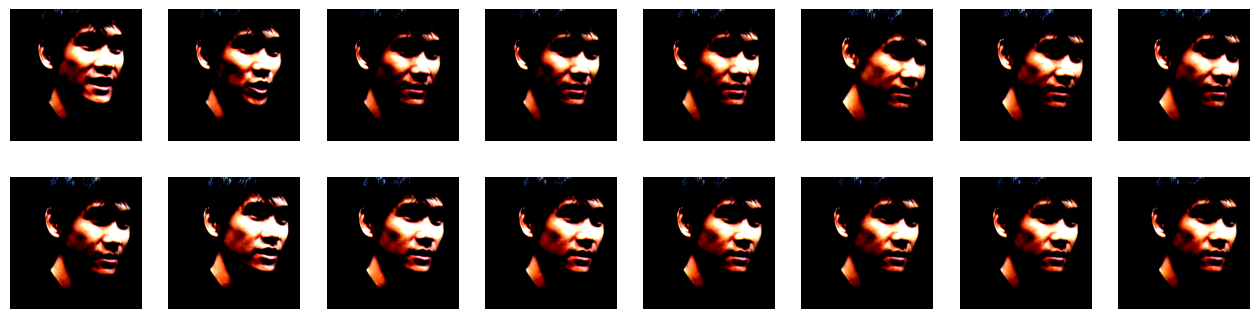

In [49]:
dataset_train.set_format(type="numpy")
item = dataset_train["train"][0]

frames = item["pixel_values"]
captions = item["labels"]

captions = tokenizer.batch_decode(captions, skip_special_tokens=True)
for caption in captions:
    print(caption)

FRAMES_PER_VIDEO = 16
rows = 2
cols = FRAMES_PER_VIDEO // rows
fig = plt.figure(figsize=(16, 4))

for i in range(FRAMES_PER_VIDEO):
    frame = frames[i]
    frame = np.moveaxis(frame, 0, 2)
    
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(frame)
    plt.axis("off")

In [ ]:
def preprocess(example):
    video_id = example["videoID"]
    captions = example["enCap"]
    
    videos_path = "dataset/videos"
    video_path = os.path.join(videos_path, "%s.mp4" % video_id)
    if not os.path.isfile(video_path):
        video_path = os.path.join(videos_path, "%s.webm" % video_id)
    
    # count number of frames
    video = cv2.VideoCapture(video_path)
    frame_count = 0
    while True:
        ret, _ = video.read()
        if not ret:
            break
        frame_count += 1
    video.release()
        
    # fixed frame sampling
    indices = np.linspace(0, frame_count, num=FRAMES_PER_VIDEO, endpoint=False).astype(np.int64)
    # random frame sampling
    #indices = np.sort(np.random.uniform(low=0, high=frame_count, size=self.num_frames).astype(np.int64))
    
    # get frames
    video = cv2.VideoCapture(video_path)
    frames = []
    frame_count, frame_idx = 0, 0
    while frame_idx < len(indices):
        if frame_count == indices[frame_idx]:
            _, frame = video.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            frame_idx += 1
        else:
            video.grab()
        frame_count += 1
    video.release()
        
    # longest caption
    max_len = -np.inf
    caption = None
    for cap in captions:
        length = len(cap.split(" "))
        if length > max_len:
            max_len = length
            caption = cap
    # random caption
    #caption = captions[random.randint(0, 9)]

    labels = tokenizer(caption, padding="max_length").input_ids
    return {"pixel_values": frames, "labels": labels}
    
    # pixel_values = image_processor(frames, return_tensors="pt").pixel_values
    # labels = tokenizer(caption, padding="max_length").input_ids
    # return {"pixel_values": pixel_values[0], "labels": labels}

In [2]:
# load json data
data_files = {"train": "dataset/vatex_train_captions.json", "validation": "dataset/vatex_val_captions.json"}
dataset = load_dataset("json", data_files=data_files)
dataset

# dataset["train"] = dataset["train"].select(np.arange(6))
# dataset["validation"] = dataset["validation"].select(np.arange(3))

# dataset = dataset.map(function=preprocess, remove_columns=["enCap", "chCap"])
# dataset.save_to_disk("dataset/raw_frames_16")

Using custom data configuration default-dc0812067ce11954
Found cached dataset json (/home/922201615/.cache/huggingface/datasets/json/default-dc0812067ce11954/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['videoID', 'enCap', 'chCap'],
        num_rows: 22895
    })
    validation: Dataset({
        features: ['videoID', 'enCap', 'chCap'],
        num_rows: 2643
    })
})